In [1]:
import numpy as np

In [2]:
import networkx as nx

In [3]:
import matplotlib.pyplot as plt
import random

In [ ]:
#plt.subplot()

In [4]:
def givemeinfo(v,e,c):
    if e < v-1:
        print('边太少')
        return None
    #e大小要适量
    D = nx.DiGraph()
    leaves=[]
    while(True):
        nx.generators.directed.gn_graph(v-1,create_using = D)
        tmp = [x[0] for x in list(D.in_degree()) if x[1] == 0]
        leafnum = len(tmp)
        if D.number_of_edges() + leafnum <= e:
            leaves = tmp.copy()
            break
    #nx.draw(D,with_labels=True)
    
    my_dict = nx.shortest_path_length(nx.reverse_view(D),source=0)
    mylst = list(zip(my_dict.values(), my_dict.keys()))
    #print(my_dict)
    #print(mylst)
    #print(leaves)
    D.add_node(v-1)
    for each in leaves:
        fea = [x[1] for x in mylst if x[0]>my_dict[each]]
        fea.append(v-1)
        D.add_edge(random.choice(fea),each)
    return D.reverse()

True
[(0, 1), (0, 2), (0, 3), (0, 6), (1, 9), (2, 5), (3, 4), (4, 7), (5, 7), (6, 9), (7, 8), (8, 9)]


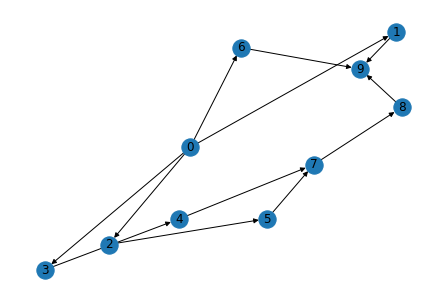

In [41]:
aoe = givemeinfo(10,20,3)
print(nx.is_directed_acyclic_graph(aoe))
#nx.info(ts)--=0
list(aoe.nodes)
print(list(aoe.edges))
nx.draw(aoe,with_labels=True)

In [10]:
def allocation(dag,agentinfo,timelimit):
    basebid = {}
    relativebid = []
    welfare = 0.0
    for e in list(dag.edges):
        agentinfo[e].sort(key = lambda x:x[1])
        basebid[e] = agentinfo[e][0][0]
        filt = [(agentinfo[e][i][0]-basebid[e],agentinfo[e][i][1],agentinfo[e][i][2],agentinfo[e][i][3]) for i in range(len(agentinfo[e]))if i > 0 and agentinfo[e][i][0] > agentinfo[e][i-1][0]]
        relativebid.extend(filt)
        dag.edges[e[0],e[1]]['weight'] = agentinfo[e][0][1]
        welfare = welfare + agentinfo[e][0][1]
    if nx.dag_longest_path_length(dag) > timelimit:
        print('mission impossible')
        return -1
    vis = {}
    relativebid.sort(key = lambda x:x[0])
    while relativebid != []:
        if len(vis) == dag.number_of_edges():
            break
        item = relativebid.pop()
        if item[2] in vis:
            continue
        tmp = dag.edges[item[2][0],item[2][1]]['weight']
        dag.edges[item[2][0],item[2][1]]['weight'] = item[1]
        if nx.dag_longest_path_length(dag) > timelimit:
            dag.edges[item[2][0],item[2][1]]['weight'] = tmp
            continue
        welfare = welfare + item[0]
        vis[item[2]] = True
    return welfare

In [51]:
def dfs(dag,ind,agentinfo,timelimit,welfare):
    if ind == dag.number_of_edges():
        if nx.dag_longest_path_length(dag) > timelimit:
            return -1
        return welfare
    te=list(dag.edges)[ind]
    ms = 0.0
    for x in agentinfo[te]:
        dag.edges[te[0],te[1]]['weight'] = x[1]
        ms = max(ms,dfs(dag,ind+1,agentinfo,timelimit,welfare+x[0]))
    return ms

In [52]:
def brute(dag,agent,timelimit):
    agentinfo = agent.copy()
    for e in list(dag.edges):
        agentinfo[e].sort(key = lambda x:x[1]) 
        filt = [agentinfo[e][i] for i in range(len(agentinfo[e]))if i == 0 or agentinfo[e][i][0] > agentinfo[e][i-1][0]]
        agentinfo[e] = filt
    return dfs(dag,0,agentinfo,timelimit,0)

In [63]:
E = list(aoe.edges)
C = 4
agents={}
for e in E:
    ci = np.random.randint(1,C)
    agents[e]=[]
    for i in range(ci):
        bi = -1
        while bi <0:
            bi = 10*np.random.randn()+50
        ti = -1
        while ti <0:
            ti = np.random.randint(1,100)
        agents[e].append((bi,ti,e,i))
print(agents)

{(0, 1): [(50.539141836968255, 61, (0, 1), 0), (34.840079466986154, 71, (0, 1), 1), (29.533663072442202, 94, (0, 1), 2)], (0, 2): [(48.117458179381096, 84, (0, 2), 0), (64.37340875804382, 51, (0, 2), 1)], (0, 3): [(34.957020155060746, 52, (0, 3), 0), (64.40115684746537, 57, (0, 3), 1)], (0, 6): [(64.29468369820944, 76, (0, 6), 0)], (1, 9): [(42.28921532637304, 87, (1, 9), 0)], (2, 5): [(27.203546193679806, 21, (2, 5), 0), (51.72376246000443, 50, (2, 5), 1)], (3, 4): [(32.20432536987204, 61, (3, 4), 0)], (4, 7): [(39.276529378280465, 97, (4, 7), 0)], (5, 7): [(27.292877601962516, 70, (5, 7), 0), (43.9590137832877, 28, (5, 7), 1), (41.5508634798973, 8, (5, 7), 2)], (6, 9): [(53.60610304890886, 59, (6, 9), 0)], (7, 8): [(59.96670491346267, 99, (7, 8), 0), (60.59801973028971, 15, (7, 8), 1), (51.03534938632418, 65, (7, 8), 2)], (8, 9): [(53.32148903610446, 58, (8, 9), 0), (58.78752539246283, 62, (8, 9), 1)]}


In [64]:
allocation(aoe,agents,100000)

707.2072248016509

In [66]:
brute(aoe,agents,100000)

626.052885630166

In [ ]:
fig, ax = plt.subplots(1, 1)
from scipy.stats import norm
x = np.linspace(norm.ppf(0.001),
                norm.ppf(0.999), 100)
ax.plot(x, norm.pdf(x)/(1-norm.cdf(x)),
       'r-', lw=5, alpha=0.6, label='norm pdf')